<a href="https://colab.research.google.com/github/lakatosgabor/operator_motion/blob/main/operator_motion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Install

In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 28.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 101.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 77.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 86.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

### Pose

In [ ]:
from ultralytics import YOLO

img1 = "/content/drive/MyDrive/PhD/Saját cikkek/Operátor követés/1.png"
img2 = "/content/drive/MyDrive/PhD/Saját cikkek/Operátor követés/2.jpg"
img3 = "/content/drive/MyDrive/PhD/Saját cikkek/Operátor követés/3.jpg"
img4 = "/content/drive/MyDrive/PhD/Saját cikkek/Operátor követés/4.jpg"

# Load a model
model = YOLO("yolo11n-pose.pt")  # load an official model

# Predict with the model
results = model(img3)  # predict on an image

# Access the results
for result in results:
    xy = result.keypoints.xy  # x and y coordinates
    xyn = result.keypoints.xyn  # normalized
    kpts = result.keypoints.data  # x, y, visibility (if available)


image 1/1 /content/drive/MyDrive/PhD/Saját cikkek/Operátor követés/3.jpg: 448x640 2 persons, 11.1ms
Speed: 2.5ms preprocess, 11.1ms inference, 2.2ms postprocess per image at shape (1, 3, 448, 640)


Személy 1: RGB=[ 77 110 193] → operator
Személy 2: RGB=[148  36  48] → muszakvezeto


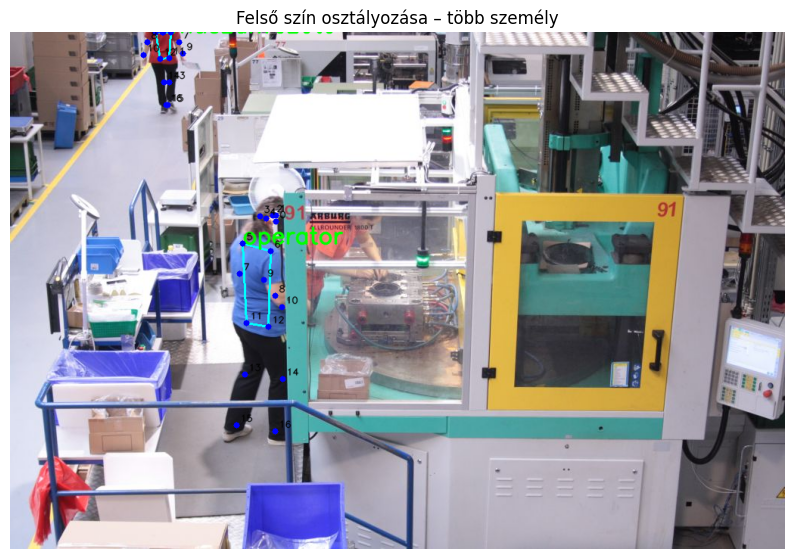

In [ ]:
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt

def classify_color(rgb):
    r, g, b = rgb
    brightness = (r + g + b) / 3
    rg_diff = abs(r - g)
    rb_diff = abs(r - b)
    gb_diff = abs(g - b)

    # Szürkék és fehér különválasztása
    if rg_diff < 20 and rb_diff < 20 and gb_diff < 20:
        if brightness > 140:
            return "operator"
        else:
            return "MEO"

    # Színes kategóriák
    if r > 140 and g < 100 and b < 100:
        return "muszakvezeto"
    if g > 150 and r < 100 and b < 100:
        return "zold"
    if b > 150 and r < 120 and g < 120:
        return "operator"
    if r > 200 and g > 200 and b < 100:
        return "sarga"
    if r > 200 and g > 150 and b < 80:
        return "narancs"
    if r > 200 and b > 200 and g < 150:
        return "rozsaszin"
    if r > 100 and g > 50 and b < 50:
        return "barna"

    return "ismeretlen"



# Kép beolvasása
image = cv2.imread(img3)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Felsőtest régió pontjai
region_kpts = [5, 6, 12, 11]  # bal váll, jobb váll, jobb csípő, bal csípő

for result in results:
    keypoints = result.keypoints.xy  # [num_persons, num_keypoints, 2]

    if keypoints is None:
        continue

    for person_id, person in enumerate(keypoints):
        # Kulcspontok lekérése
        region_points = []
        for idx in region_kpts:
            x, y = person[idx]
            if torch.isnan(x) or torch.isnan(y):
                continue
            region_points.append((int(x.item()), int(y.item())))

        if len(region_points) == 4:
            # Maszk a felsőtest területre
            mask = np.zeros(image_rgb.shape[:2], dtype=np.uint8)
            cv2.fillPoly(mask, [np.array(region_points)], 255)

            region_pixels = image_rgb[mask == 255]
            if len(region_pixels) == 0:
                continue

            mean_color = np.mean(region_pixels, axis=0).astype(int)  # RGB
            color_name = classify_color(mean_color)

            # Kiírás
            print(f"Személy {person_id + 1}: RGB={mean_color} → {color_name}")

            # Rajz: régió + felirat
            cv2.polylines(image_rgb, [np.array(region_points)], isClosed=True, color=(0, 255, 255), thickness=2)
            cv2.putText(image_rgb, f"{color_name}", region_points[0],
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)

        # Kulcspontok kirajzolása
        for idx, (x, y) in enumerate(person):
            if torch.isnan(x) or torch.isnan(y):
                continue
            x_int, y_int = int(x.item()), int(y.item())
            cv2.circle(image_rgb, (x_int, y_int), 4, (0, 0, 255), -1)
            cv2.putText(image_rgb, str(idx), (x_int + 5, y_int - 5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 0, 0), 1, cv2.LINE_AA)

# Megjelenítés
plt.figure(figsize=(10, 10))
plt.imshow(image_rgb)
plt.axis('off')
plt.title("Felső szín osztályozása – több személy")
plt.show()


### Segmentation

In [ ]:
from ultralytics import YOLO
import torch
import cv2
import numpy as np

# Load model
model = YOLO("yolo11n-seg.pt")

# Input image path
img1 = "/content/drive/MyDrive/PhD/Saját cikkek/Operátor követés/1.png"

# Predict
results = model(img1)

# Process results
for i, result in enumerate(results):
    orig_img = result.orig_img.copy()
    H, W = orig_img.shape[:2]

    if result.masks is not None and result.boxes is not None:
        masks = result.masks.data.cpu().numpy()      # (n, h, w)
        class_ids = result.boxes.cls.cpu().numpy()   # osztály ID-k

        # Csak "person" class (id=0) maszkolása
        person_indices = np.where(class_ids == 0)[0]

        colors = np.random.randint(0, 255, (len(person_indices), 3), dtype=np.uint8)

        for idx_color, idx in enumerate(person_indices):
            mask = masks[idx]
            color = colors[idx_color]

            # Resize mask
            mask_resized = cv2.resize(mask.astype(np.uint8), (W, H), interpolation=cv2.INTER_NEAREST)

            # Create color mask
            colored_mask = np.zeros_like(orig_img, dtype=np.uint8)
            for c in range(3):
                colored_mask[:, :, c] = mask_resized * color[c]

            # Overlay mask on image
            alpha = 0.5
            orig_img = cv2.addWeighted(orig_img, 1, colored_mask, alpha, 0)

    output_path = f"masked_output_{i}.jpg"
    cv2.imwrite(output_path, orig_img)
    print(f"✅ Maszkolt kép mentve: {output_path}")



image 1/1 /content/drive/MyDrive/PhD/Saját cikkek/Operátor követés/1.png: 448x640 4 persons, 1 chair, 2 tvs, 1 keyboard, 10.8ms
Speed: 2.5ms preprocess, 10.8ms inference, 2.4ms postprocess per image at shape (1, 3, 448, 640)
✅ Maszkolt kép mentve: masked_output_0.jpg


### Tracking

In [ ]:
!pip install ultralytics deep_sort_realtime opencv-python scikit-learn torchvision

In [ ]:
!pip install yt-dlp
!apt-get install -y ffmpeg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.4/175.4 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 71.9 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [ ]:
!yt-dlp -f best -o "test_video.mp4" "https://www.youtube.com/watch?v=3FXUw98rrUY"

         To let yt-dlp download and merge the best available formats, simply do not pass any format selection.
         If you know what you are doing and want only the best pre-merged format, use "-f b" instead to suppress this warning
[youtube] Extracting URL: https://www.youtube.com/watch?v=3FXUw98rrUY
[youtube] 3FXUw98rrUY: Downloading webpage
[youtube] 3FXUw98rrUY: Downloading tv client config
[youtube] 3FXUw98rrUY: Downloading player 27b58bb9-main
[youtube] 3FXUw98rrUY: Downloading tv player API JSON
[youtube] 3FXUw98rrUY: Downloading ios player API JSON
[youtube] 3FXUw98rrUY: Downloading m3u8 information
[info] 3FXUw98rrUY: Downloading 1 format(s): 18
[download] Destination: test_video.mp4
[download] 100% of    3.08MiB in 00:00:00 at 5.65MiB/s


In [ ]:
import cv2
import torch
import torchvision.transforms as T
from torchvision.models import resnet50
from ultralytics import YOLO
from deep_sort_realtime.deepsort_tracker import DeepSort
from sklearn.metrics.pairwise import cosine_similarity
from PIL import Image
import numpy as np
# A cv2_imshow szükséges a valós idejű megjelenítéshez Colab-ban
from google.colab.patches import cv2_imshow
# Az IPython.display.Video és display már nem szükséges, mivel valós idejű megjelenítést használunk
# from IPython.display import Video, display

# --- Embedder modell (ResNet50, ImageNet-pretrained) ---
# Eszköz kiválasztása: GPU (CUDA) ha elérhető, különben CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# ResNet50 modell betöltése előre betanított súlyokkal
embedder_model = resnet50(pretrained=True)
# Eltávolítjuk az utolsó osztályozó réteget, hogy jellemzők kinyerésére használjuk
embedder_model.fc = torch.nn.Identity()
# Modellt áthelyezzük a kiválasztott eszközre és beállítjuk kiértékelési módba
embedder_model = embedder_model.to(device).eval()

# Kép előfeldolgozási transzformációk definiálása
transform = T.Compose([
    T.Resize((128, 64)), # Kép átméretezése a modell bemeneti méretéhez
    T.ToTensor(),       # Kép konvertálása PyTorch tenzorrá
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Normalizálás
])

# Függvény a kivágott kép beágyazásának (embedding) generálásához
def get_embedding(crop):
    img = Image.fromarray(crop) # NumPy tömbből PIL képpé alakítás
    with torch.no_grad(): # Gradiens számítás kikapcsolása a memóriahatékonyság érdekében
        tensor = transform(img).unsqueeze(0).to(device) # Előfeldolgozás és eszközre helyezés
        embedding = embedder_model(tensor).cpu().numpy() # Beágyazás generálása és CPU-ra helyezés
    return embedding / np.linalg.norm(embedding) # Normalizált beágyazás visszaadása

# --- YOLO + DeepSORT inicializálása ---
# YOLO modell betöltése (yolov8n-pose.pt) - ez automatikusan letöltődik, ha nincs meg
model = YOLO("yolov11n-pose.pt")
# DeepSORT nyomkövető inicializálása
# max_age: hány képkockán keresztül tartjuk meg a nyomvonalat, ha nem észlelhető az objektum
# n_init: hány sikeres észlelés kell egy új nyomvonal megerősítéséhez
tracker = DeepSort(max_age=20, n_init=3)

# --- Re-ID adatbázis ---
# Szótár az azonosított személyen beágyazásainak tárolására
reid_database = {}

# --- Videó beolvasás ---
# A feldolozandó videó elérési útja (győződjön meg róla, hogy a 'test_video.mp4' feltöltésre került a Colab-ba)
video_path = "/content/test_video.mp4"
cap = cv2.VideoCapture(video_path)

# Ellenőrizzük, hogy a videó sikeresen megnyílt-e
if not cap.isOpened():
    print(f"Hiba: Nem sikerült megnyitni a videót a következő útvonalon: {video_path}")
    exit() # Kilépés, ha a videó nem nyitható meg

# --- Kimeneti videó beállítás ---
output_path = "/content/output_annotated.mp4" # A feldolgozott videó mentési útvonala
fourcc = cv2.VideoWriter_fourcc(*'mp4v') # Videó kodek (MP4V a .mp4 fájlokhoz)
fps = cap.get(cv2.CAP_PROP_FPS) # Eredeti videó képkocka sebessége
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)) # Eredeti videó szélessége
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)) # Eredeti videó magassága

# Ellenőrizzük, hogy a videó méretei érvényesek-e
if width == 0 or height == 0:
    print(f"Hiba: Érvénytelen videó méretek: Szélesség={width}, Magasság={height}. Ellenőrizze a videófájlt.")
    exit() # Kilépés, ha a méretek érvénytelenek

# Kimeneti videó író objektum létrehozása
out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

next_custom_id = 0 # Számláló az új, egyedi személyazonosítókhoz
frame_count = 0 # Képkocka számláló
print("Videó feldolgozása megkezdődött. A képkockák valós időben jelennek meg.")

# --- Videófeldolgozó ciklus ---
while cap.isOpened():
    ret, frame = cap.read() # Képkocka olvasása
    if not ret: # Ha nincs több képkocka, vagy hiba történt
        break

    results = model(frame)[0] # YOLO modell futtatása a képkockán
    detections = [] # Észlelések listája

    for box in results.boxes:
        cls = int(box.cls[0]) # Észlelt objektum osztálya
        if cls != 0: # Csak a "person" (0-ás osztály) észleléseket vesszük figyelembe
            continue
        x1, y1, x2, y2 = map(int, box.xyxy[0]) # Észlelési doboz koordinátái
        conf = float(box.conf[0]) # Konfidencia pontszám
        detections.append(([x1, y1, x2 - x1, y2 - y1], conf, 'person')) # Hozzáadás a detekciókhoz

    tracks = tracker.update_tracks(detections, frame=frame) # DeepSORT nyomkövető frissítése

    for track in tracks:
        if not track.is_confirmed(): # Csak a megerősített nyomvonalakat vesszük figyelembe
            continue

        x1, y1, x2, y2 = map(int, track.to_ltrb()) # Nyomvonal doboz koordinátái
        # Biztosítsuk, hogy a kivágási koordináták a képkocka határain belül legyenek
        x1 = max(0, x1)
        y1 = max(0, y1)
        x2 = min(width, x2)
        y2 = min(height, y2)

        crop = frame[y1:y2, x1:x2] # Kivágjuk a személyt a képkockáról
        if crop.shape[0] == 0 or crop.shape[1] == 0: # Ellenőrizzük, hogy a kivágás nem üres-e
            continue

        emb = get_embedding(crop) # Beágyazás generálása a kivágott képről

        # --- Re-ID összehasonlítás ---
        matched_id = None
        max_sim = 0.0
        # Összehasonlítjuk az új beágyazást az adatbázisban lévő összes beágyazással
        for db_id, (db_emb, _) in reid_database.items():
            sim = cosine_similarity(emb, db_emb)[0][0] # Koszinusz hasonlóság számítása
            if sim > 0.75 and sim > max_sim: # Ha a hasonlóság elég magas és jobb, mint az eddigi legjobb
                matched_id = db_id # Megtaláltuk a megfelelő azonosítót
                max_sim = sim

        if matched_id is None: # Ha nem találtunk egyező személyt az adatbázisban
            matched_id = f"person_{next_custom_id}" # Új egyedi azonosító generálása
            reid_database[matched_id] = (emb, crop) # Hozzáadjuk az adatbázishoz
            next_custom_id += 1 # Számláló növelése

        # Téglalap rajzolása a személy köré és az azonosító kiírása
        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(frame, f"ReID: {matched_id}", (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

    # --- Képkocka megjelenítése valós időben Colab-ban ---
    cv2_imshow(frame)
    # Kis késleltetés, hogy a megjelenítés ne legyen túl gyors (opcionális)
    # cv2.waitKey(1)

    # --- Kimeneti videóhoz mentés ---
    out.write(frame) # Az annotált képkocka mentése a kimeneti videóba
    frame_count += 1
    # Folyamatjelző kiírása 5 másodpercenként
    if fps > 0 and frame_count % (int(fps) * 5) == 0:
        print(f"Feldolgozott képkockák: {frame_count} ({frame_count / fps:.1f} másodperc)")

print("Videó feldolgozása befejeződött.")
cap.release() # Videó beolvasó felszabadítása
out.release() # Videó író felszabadítása
cv2.destroyAllWindows() # Ablakok bezárása (bár Colab-ban nem mindig szükséges)

print(f"A feldolgozott videó mentve ide: {output_path}")
